# Check the read in stellar evolutionary tracks formatted by me and the one shared by Ilaria

In [1]:
import numpy as np
import pandas as pd

import os, sys, tqdm, copy, re

import tqdm
import tqdm.notebook

import matplotlib.pyplot as plt
import matplotlib

style = [
    'seaborn-ticks',
    {
        'figure.dpi': 300,
        'font.size': 12,
        'image.cmap': 'inferno',
        'font.family': 'serif',
        'font.serif': ['Times', 'Times New Roman'] + plt.rcParams['font.serif'],
        'xtick.top': True,
        'xtick.direction': 'in',
        'ytick.right': True,
        'ytick.direction': 'in',
        'mathtext.fontset': 'cm'
        }]
plt.style.use(style)

import scipy.io

# github_dir = '/home/dingshandeng/github/ysoisochrone/'
github_dir = '/Users/dingshandeng/github/ysoisochrone/'

os.chdir(os.path.join(github_dir, 'tests'))
sys.path.append(os.path.join(github_dir))
import ysoisochrone.utils as utils
import ysoisochrone.bayesian

#### Load the datafile from Python

In [2]:
# Load the saved .mat file
loaded_data_py = scipy.io.loadmat('./isochrones_data_archive/Feiden_AgeMassGrid_YSO_matrix.mat')

# Access the data
masses_py = loaded_data_py['mass'][0]
log_age_py = loaded_data_py['log_age'][0]
logtlogl_py = loaded_data_py['logt_logl']

#### The datafile from IDL

In [3]:
loaded_data_idl = scipy.io.readsav('./isochrones_data_archive/Feiden_AgeMassGrid.sav')
masses_idl = loaded_data_idl['mass']
log_age_idl = loaded_data_idl['log_age']
logtlogl_idl = loaded_data_idl['logt_logl']

## The function for comparisons

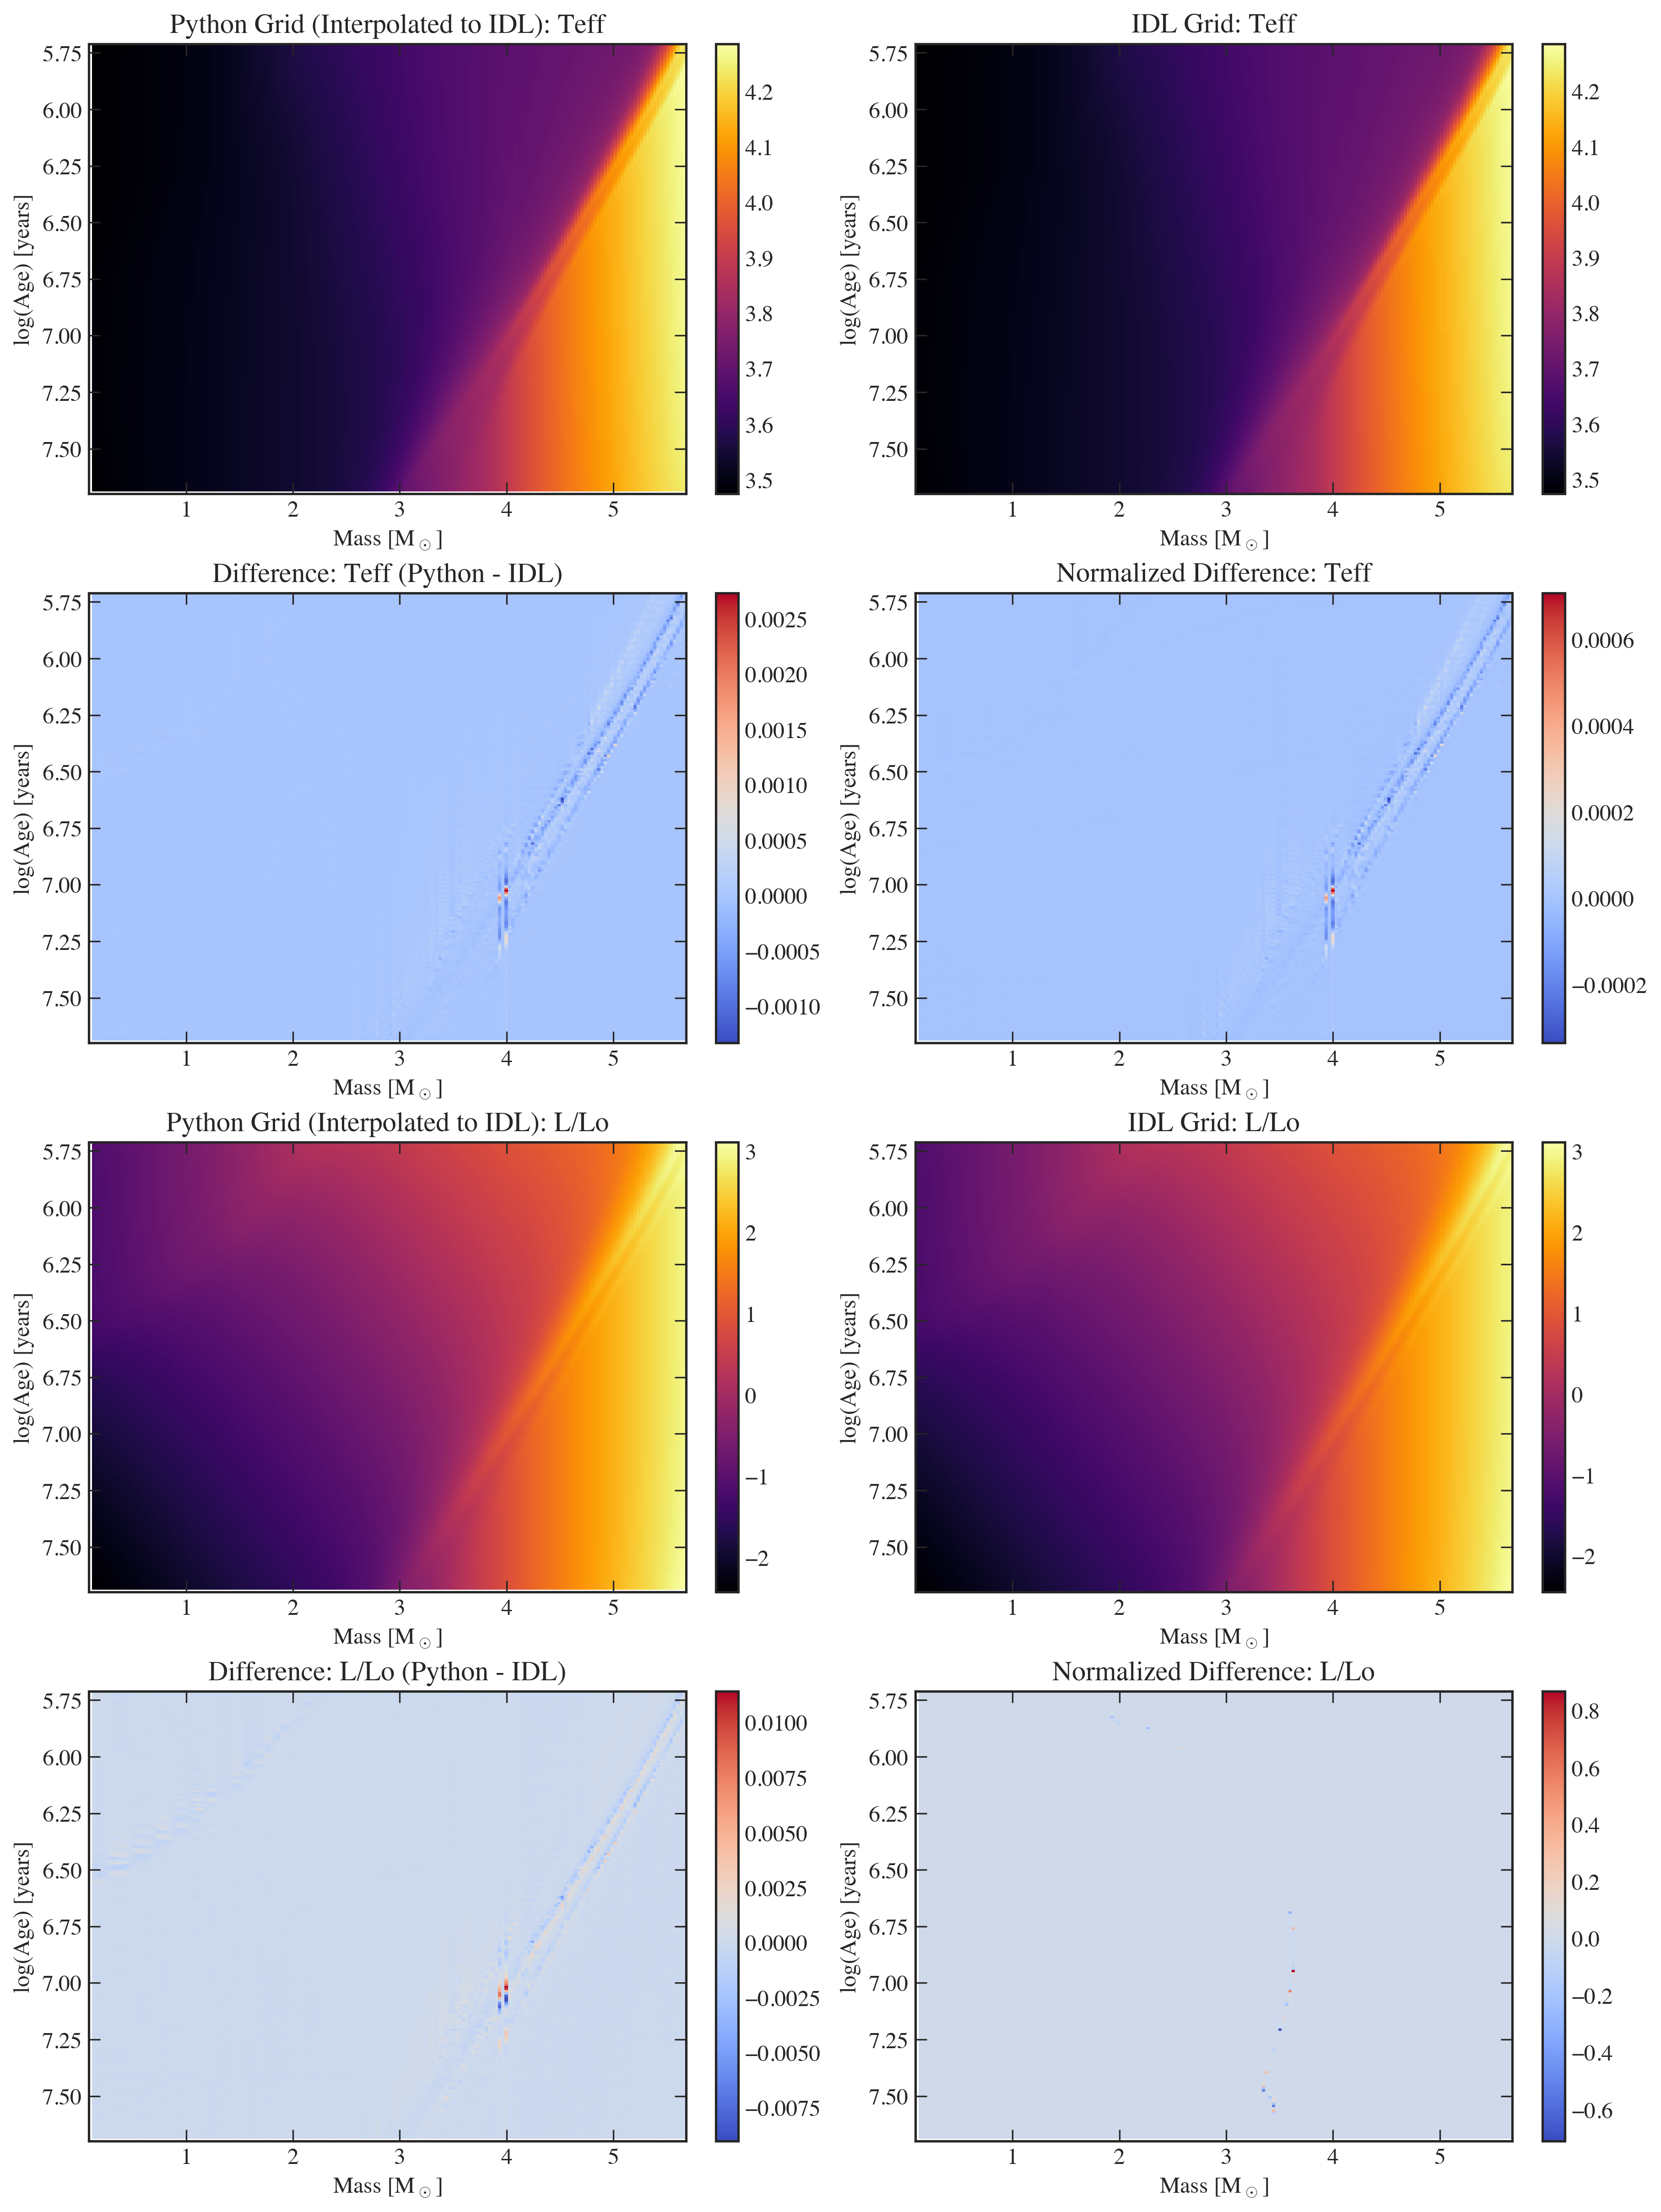

In [4]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import griddata

# Example usage
# loaded_data_py = scipy.io.loadmat('./isochrones_data/Feiden_trkP2016_AgeMassGrid_YSO_matrix.mat')
# loaded_data_idl = scipy.io.readsav('./isochrones_data/Feiden_AgeMassGrid.sav')

# Compare the grids
# compare_grids(loaded_data_py, loaded_data_idl)
logtlogl_diff, logtlogl_diff_norm = utils.compare_grids(loaded_data_py, loaded_data_idl) # , gridnames=['web', 'shared'])